In [1]:
%load_ext autoreload
%autoreload 2
import jupyter_black

jupyter_black.load(line_length=79)

In [2]:
from glob import glob

import polars as pl
import numpy as np
import matplotlib.pyplot as plt

import aqr
from aqr.qr_params import QRParams

### Initialising Parameters

In [3]:
# This is a small utility that I use to load my files
# I precompute some relevant quantities in and estimations
# folder that I aggregate over a date range of my choice to
# get QR statistics estimations. This class helps me do that
# My estimation files are very close to what your research/run/ferrari/alpha.py
# script outputs if I am not mistaken.
loader: QRParams = QRParams(data_dir="../data/QR/v1")

ticker = "AAL"
model_rng = np.random.default_rng(1337)
lob_rng = np.random.default_rng(42)

lob_params = {
    "bid_prices": [999, 1000],
    "bid_volumes": [2, 3],
    "ask_volumes": [5, 7],
    "ask_prices": [1002, 1003],
}
lob = aqr.config.init_lob(loader, ticker, **lob_params, lob_rng=lob_rng)

In [68]:
# I created a little utility to parse json configs for SLURM jobs at first but
# I ended up finding it actually handy
config = {
    "ticker": "AAL",
    "qr_offset": 1,  # QR intensities are multiplied by this factor to slow it down
    "alpha": {
        "type": "imbalance",
        "params": {
            "beta_imb": 0.8,
            "beta_eps": 1,
            "lamda_dt": 10 * 1e9,
            "lamda_eps": 0.15,
            "eps_max": 0.15,
            "eps_min": -0.15,
        },
    },
    "matching_engine": {"l1": 1847, "l2": 1830, "delta": 30000, "gamma": 0.65},
    "race_model": {
        "type": "simple_race",
        "params": {
            "race_id": 1,
            "p_min": 0.4,
            "p_max": 0.9,
            "theta_min": 0.4,
            "theta_max": 0.9,
            "alpha_lower": 0.6,
            "alpha_upper": 1.0,
            "max_spread": 1,
            "event_weights": [0.65, 0.35],
            "full_alpha": True,
        },
    },
    "external_event_model": {
        "type": "exp_event",
        "params": {
            "lamda": 2000000000,
            "race_id": 2,
            "theta_N": 0.4,
            "theta_p": 0.3,
            "imb_corr": -1,
            "event_weights": [0.65, 0.35],
        },
    },
    "impact_model": {
        "coef": 0,
        "max_size": 1000,
    },
    "trader": {
        "trader_id": 1,
        "max_spread": 1,
        "max_volume": 5,
        "alpha_threshold": 0.7,
        "max_pos": 15,
        "probability_": 0.4,
        "cooldown": 1,
        "full_alpha": True,
    },
    "hours": 5.5,
}

aqr_params = {
    **aqr.config.parse_config(config, loader, model_rng),
    "rng": model_rng,
}

aqr_model = aqr.alpha_qr.AQR(**aqr_params)

In [69]:
!rm -rf tmp
buffer = aqr.buffer.Buffer(max_size=10_000, checkpoint_dir="tmp")
aqr_model.sample(
    lob, max_ts=int(1e9 * 3600 * 5.5), buffer=buffer
)  # 5.5 hours of trading

Checkpoint saved to tmp/checkpoint_0.parquet
Checkpoint saved to tmp/checkpoint_1.parquet
Checkpoint saved to tmp/checkpoint_2.parquet
Checkpoint saved to tmp/checkpoint_3.parquet
Checkpoint saved to tmp/checkpoint_4.parquet
Checkpoint saved to tmp/checkpoint_5.parquet
Checkpoint saved to tmp/checkpoint_6.parquet
Checkpoint saved to tmp/checkpoint_7.parquet
Checkpoint saved to tmp/checkpoint_8.parquet
Checkpoint saved to tmp/checkpoint_9.parquet
Checkpoint saved to tmp/checkpoint_10.parquet


In [84]:
df = (
    pl.concat(
        [
            *[pl.scan_parquet(f) for f in glob("tmp/*.parquet")],
            buffer.to_df().lazy(),
        ]
    )
    .sort(by="dt")
    .collect()
)

In [85]:
df_emp = (
    loader.load_raw_files(ticker=ticker)
    .filter(
        pl.col("event_queue_nbr").ge(pl.col("best_bid_nbr").sub(1))
        & pl.col("event_queue_nbr").le(pl.col("best_ask_nbr").add(1))
    )
    .collect()
)

In [86]:
df.head()

sequence,ts,xt,dt,imbalance,spread,alpha,eps,side,price,size,event,partial,rejected,race,trader_id,trader_pos,P_-4_sent,P_-3_sent,P_-2_sent,P_-1_sent,Q_-4_sent,Q_-3_sent,Q_-2_sent,Q_-1_sent,Q_1_sent,Q_2_sent,Q_3_sent,Q_4_sent,P_1_sent,P_2_sent,P_3_sent,P_4_sent,P_-4_event,P_-3_event,P_-2_event,P_-1_event,Q_-4_event,Q_-3_event,Q_-2_event,Q_-1_event,Q_1_event,Q_2_event,Q_3_event,Q_4_event,P_1_event,P_2_event,P_3_event,P_4_event,P_-4_recv,P_-3_recv,P_-2_recv,P_-1_recv,Q_-4_recv,Q_-3_recv,Q_-2_recv,Q_-1_recv,Q_1_recv,Q_2_recv,Q_3_recv,Q_4_recv,P_1_recv,P_2_recv,P_3_recv,P_4_recv
i64,i64,i64,i64,f64,i64,f64,f64,i8,i64,i64,str,bool,bool,i8,i8,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64
0,396117827,396119674,396151504,0.7,1,0.545455,null,1,944,2,"""Can""",false,false,0,0,0,940,941,942,943,12,16,19,17,5,17,11,16,944,945,946,947,940,941,942,943,12,16,19,17,5,17,11,16,944,945,946,947,940,941,942,943,12,16,19,17,3,17,11,16,944,945,946,947
1,396151504,396153351,396185181,0.789474,1,0.7,null,1,944,1,"""Can""",false,false,1,0,0,940,941,942,943,12,16,19,17,3,17,11,16,944,945,946,947,940,941,942,943,12,16,19,17,3,17,11,16,944,945,946,947,940,941,942,943,12,16,19,17,2,17,11,16,944,945,946,947
2,396185181,396187028,396218858,0.0,2,0.789474,null,1,944,2,"""Trd""",false,false,1,0,0,940,941,942,943,12,16,19,17,2,17,11,16,944,945,946,947,940,941,942,943,12,16,19,17,2,17,11,16,944,945,946,947,940,941,942,943,12,16,19,17,17,11,16,18,945,946,947,948
2,396185181,396187028,396218858,-0.7,1,0.789474,null,-1,944,3,"""Create_Bid""",false,false,1,0,0,940,941,942,943,12,16,19,17,2,17,11,16,944,945,946,947,940,941,942,943,12,16,19,17,17,11,16,18,945,946,947,948,941,942,943,944,16,19,17,3,17,11,16,18,945,946,947,948
3,396185181,396187028,396248171,-0.7,1,-0.7,null,1,944,0,"""Trd""",false,true,1,0,0,940,941,942,943,12,16,19,17,2,17,11,16,944,945,946,947,941,942,943,944,16,19,17,3,17,11,16,18,945,946,947,948,941,942,943,944,16,19,17,3,17,11,16,18,945,946,947,948


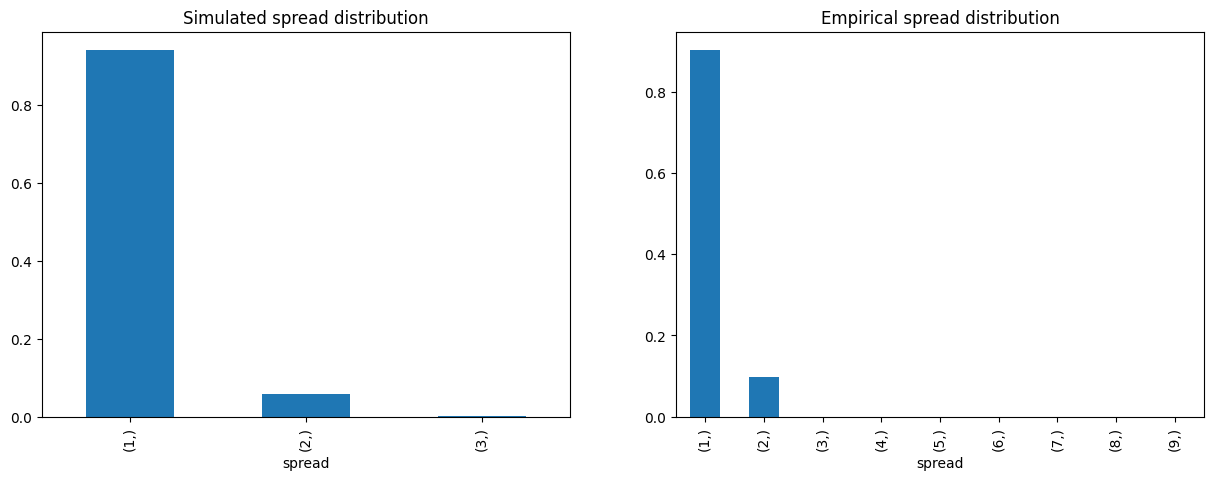

In [87]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

df.select(
    pl.col("spread").filter(~pl.col("rejected"))
).to_pandas().value_counts(normalize=True).sort_index().plot(
    kind="bar", ax=ax1
)

df_emp.select("spread").to_pandas().value_counts(
    normalize=True
).sort_index().plot(kind="bar", ax=ax2)

ax1.set_title("Simulated spread distribution")
ax2.set_title("Empirical spread distribution")
plt.show()

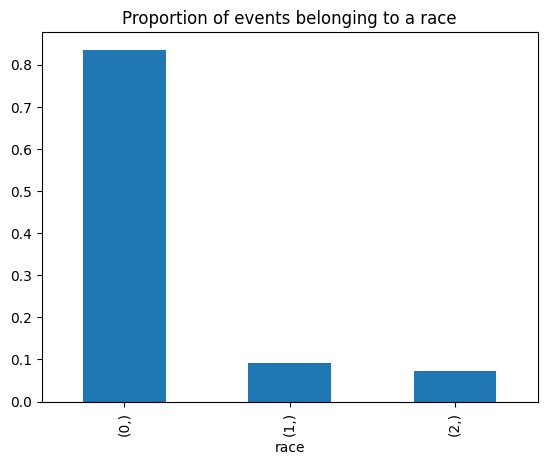

In [88]:
df.filter(pl.col("rejected").eq(False)).select(
    "race"
).to_pandas().value_counts(normalize=True).plot(kind="bar")

plt.title("Proportion of events belonging to a race")
plt.show()

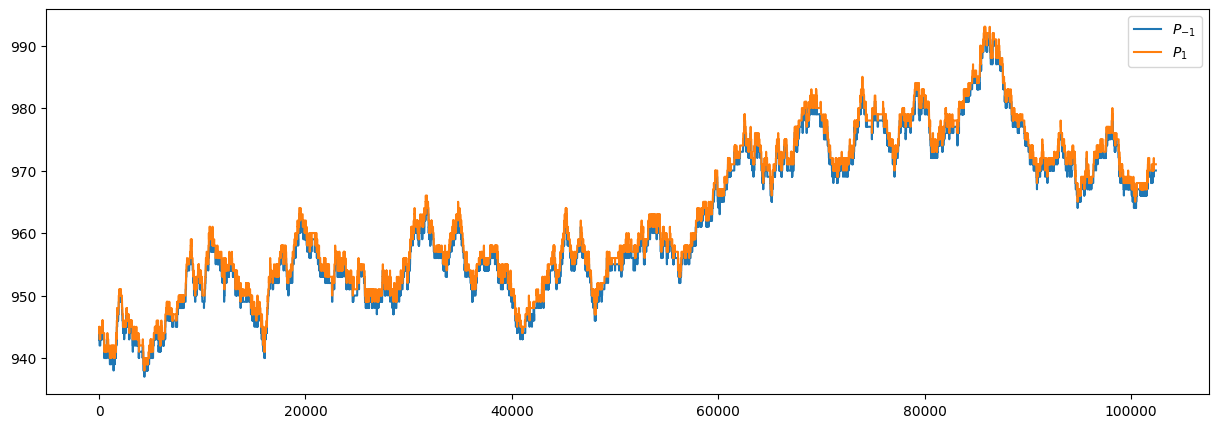

In [89]:
plt.figure(figsize=(15, 5))

plt.plot(
    df.select(pl.col("P_-1_event").filter(~pl.col("rejected"))),
    label=r"$P_{-1}$",
)
plt.plot(
    df.select(pl.col("P_1_event").filter(~pl.col("rejected"))), label=r"$P_1$"
)

plt.legend()
plt.show()

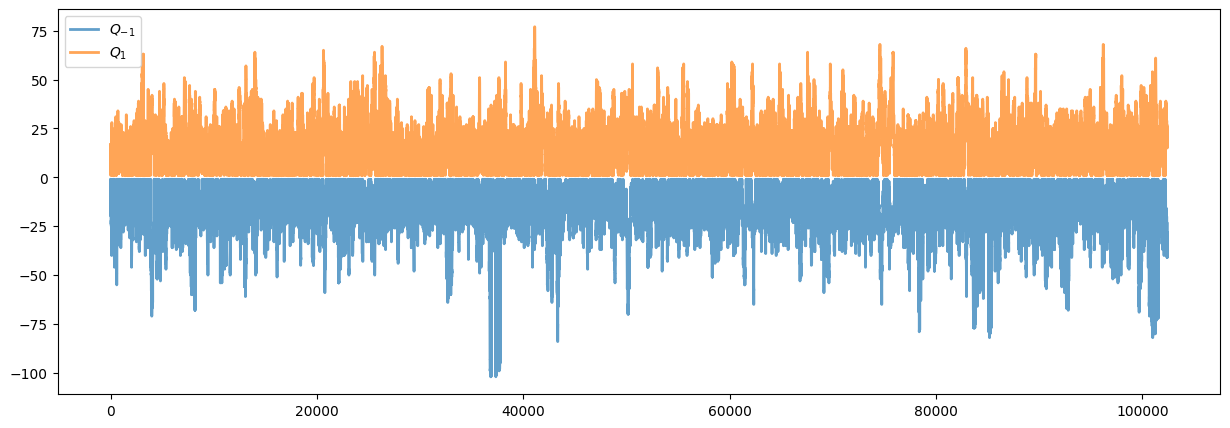

In [90]:
# Queue sizes appear to be reasonable
plt.figure(figsize=(15, 5))

plt.plot(
    df.select(-pl.col("Q_-1_event").filter(~pl.col("rejected"))),
    label=r"$Q_{-1}$",
    lw=2,
    alpha=0.7,
)
plt.plot(
    df.select(pl.col("Q_1_event").filter(~pl.col("rejected"))),
    label=r"$Q_1$",
    lw=2,
    alpha=0.7,
)

plt.legend()
plt.show()

In [91]:
ts_delta_emp = df_emp.select(
    pl.col("ts_event").diff().alias("ts_delta")
).select(pl.col("ts_delta").filter(pl.col("ts_delta").gt(0)).log10())

ts_delta = (
    df.filter(~pl.col("rejected"))
    .select(pl.col("dt").diff().alias("ts_delta"))
    .select(pl.col("ts_delta").filter(pl.col("ts_delta").gt(0)).log10())
)

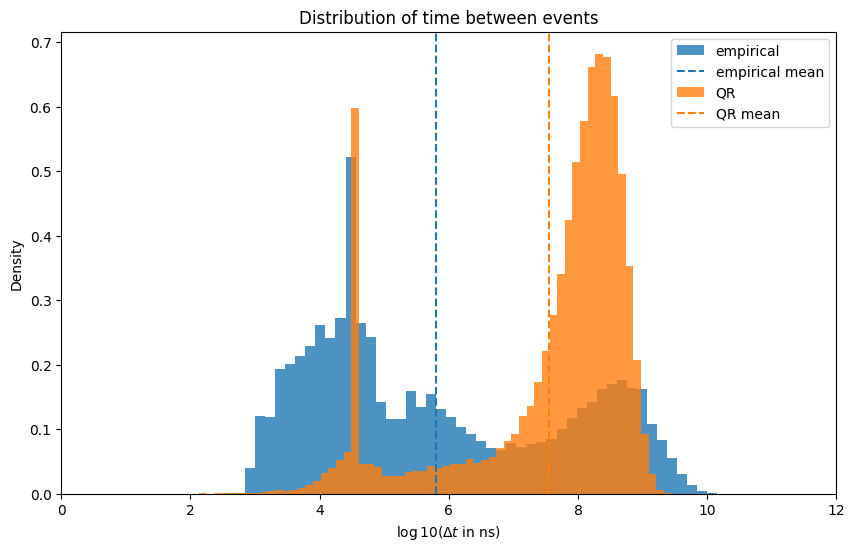

In [92]:
plt.figure(figsize=(10, 6))
plt.hist(ts_delta_emp, bins=80, label="empirical", density=True, alpha=0.8)
plt.axvline(
    ts_delta_emp.select(pl.col("ts_delta").mean()).item(),
    color="tab:blue",
    linestyle="--",
    label="empirical mean",
)

plt.hist(
    ts_delta,
    bins=80,
    label="QR",
    density=True,
    alpha=0.8,
)
plt.axvline(
    ts_delta.select(pl.col("ts_delta").mean()).item(),
    color="tab:orange",
    linestyle="--",
    label="QR mean",
)

plt.xlabel(r"$\log10$($\Delta t$ in ns)")
plt.ylabel("Density")
plt.title("Distribution of time between events")

plt.xlim(0, 12)
plt.legend()
plt.show()

In [93]:
mes = loader.compute_mes(ticker="AAL")
q_bid = (
    pl.col("Q_-1")
    .truediv(
        mes.select(
            pl.col("event_size").filter(pl.col("event_queue_nbr").eq(-1))
        )
        .collect()
        .item()
    )
    .ceil()
)
q_ask = (
    pl.col("Q_1")
    .truediv(
        mes.select(
            pl.col("event_size").filter(pl.col("event_queue_nbr").eq(1))
        )
        .collect()
        .item()
    )
    .ceil()
)
imbalance_emp = df_emp.filter(pl.col("spread").eq(1)).select(
    ((q_bid - q_ask) / (q_bid + q_ask)).alias("imbalance")
)
imbalance = df.filter(
    pl.col("P_1_recv").sub(pl.col("P_-1_recv")).eq(1)
).select(
    pl.col("Q_-1_recv")
    .sub(pl.col("Q_1_recv"))
    .truediv(pl.col("Q_-1_recv").add(pl.col("Q_1_recv")))
    .alias("imbalance")
)

NBINS: int = 10
bin_left = np.arange(-NBINS, NBINS) / NBINS
bin_right = np.arange(-NBINS + 1, NBINS + 1) / NBINS
imbalance_bin = aqr.utils.pl_select(
    condlist=[
        pl.col("imbalance").ge(left) & pl.col("imbalance").lt(right)
        for left, right in zip(bin_left, bin_right)
    ],
    choicelist=[pl.lit(left) for left in bin_left],
).alias("binned_imbalance")

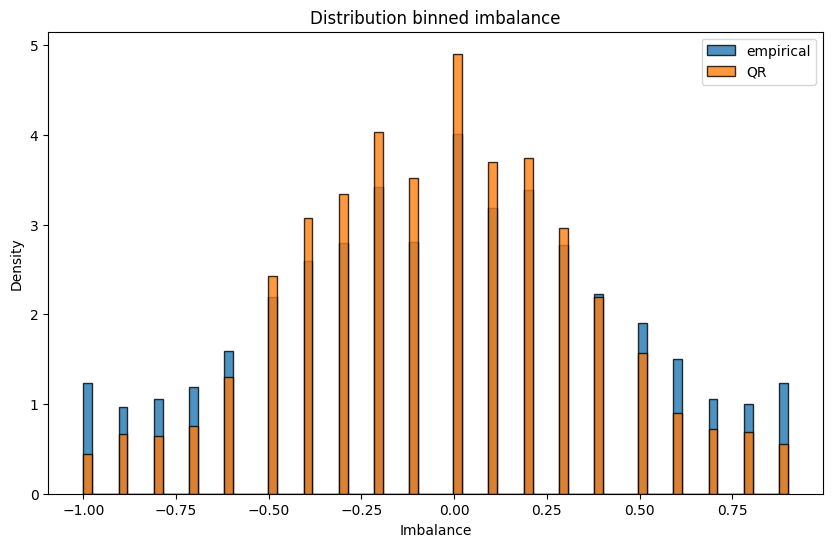

In [94]:
plt.figure(figsize=(10, 6))
plt.hist(
    imbalance_emp.select(imbalance_bin),
    bins=80,
    label="empirical",
    density=True,
    alpha=0.8,
    edgecolor="black",
)

plt.hist(
    imbalance.select(imbalance_bin),
    bins=80,
    label="QR",
    density=True,
    alpha=0.8,
    edgecolor="black",
)

plt.xlabel(r"Imbalance")
plt.ylabel("Density")
plt.title("Distribution binned imbalance")

plt.legend()
plt.show()

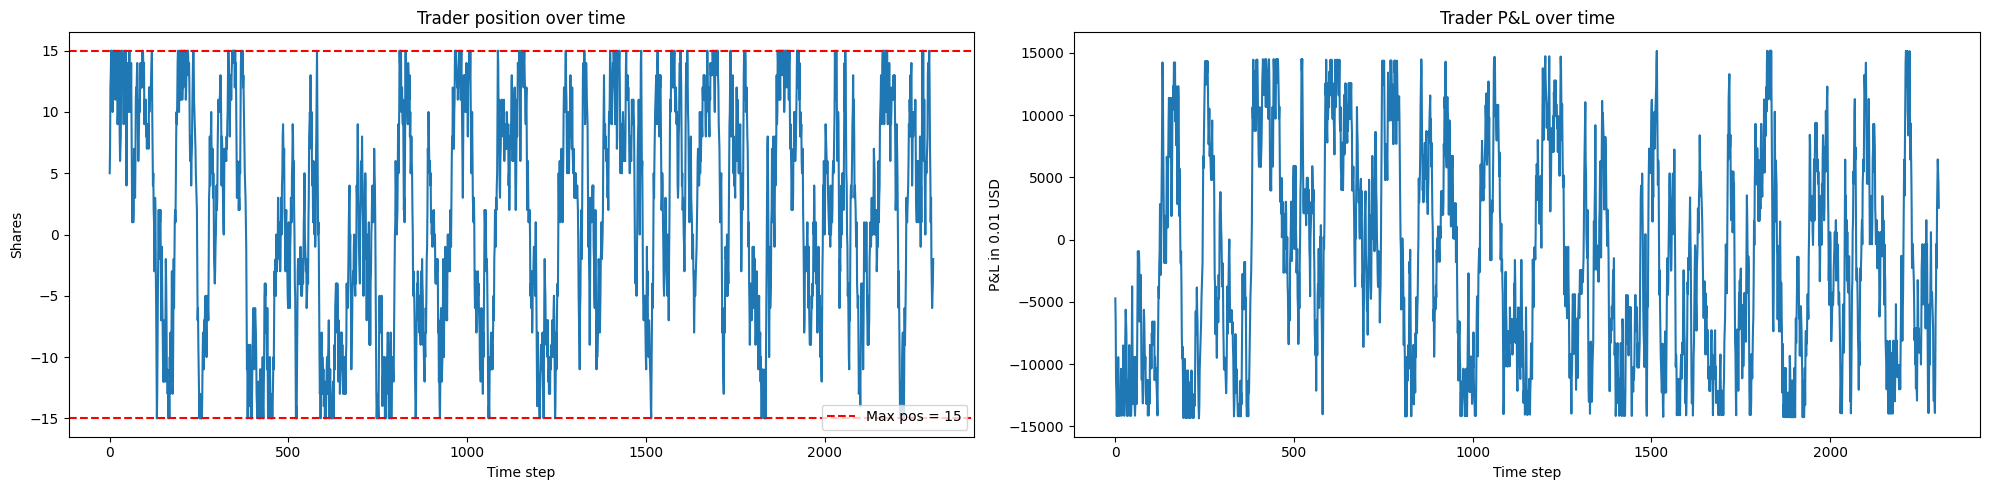

In [95]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))

ax1.plot(
    df.select(
        pl.col("size")
        .mul("side")
        .filter(pl.col("trader_id").eq(1) & pl.col("rejected").eq(False))
        .cum_sum()
    )
)

ax1.axhline(
    y=aqr_model.trader.max_pos,
    color="red",
    linestyle="--",
    label=f"Max pos = {aqr_model.trader.max_pos}",
)
ax1.axhline(y=-aqr_model.trader.max_pos, color="red", linestyle="--")

ax1.set_title("Trader position over time")
ax1.set_xlabel("Time step")
ax1.set_ylabel("Shares")
ax1.legend()

ax2.plot(
    df.select(
        pl.col("size")
        .mul("side")
        .mul("price")
        .mul(-1)
        .filter(pl.col("trader_id").eq(1) & pl.col("rejected").eq(False))
        .cum_sum()
    )
)
ax2.set_title("Trader P&L over time")
ax2.set_xlabel("Time step")
ax2.set_ylabel("P&L in 0.01 USD")

fig.tight_layout()
plt.show()
plt.close()

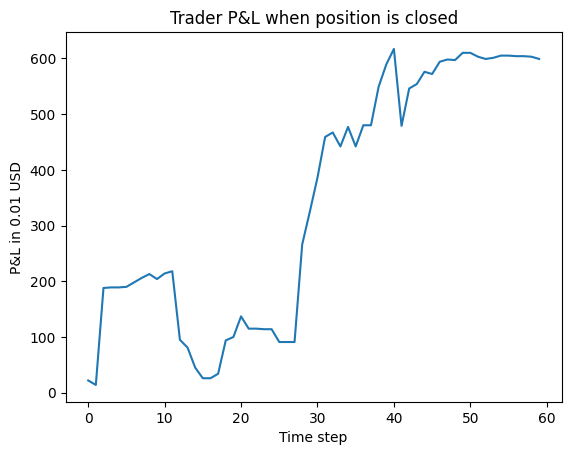

In [96]:
plt.plot(
    df.filter(pl.col("trader_id").eq(1) & pl.col("rejected").eq(False))
    .select(
        pl.col("size").mul("side").mul("price").mul(-1).cum_sum().alias("pnl"),
        pl.col("size").mul("side").cum_sum().alias("pos"),
    )
    .select(pl.col("pnl").filter(pl.col("pos").eq(0)))
)

plt.title("Trader P&L when position is closed")
plt.xlabel("Time step")
plt.ylabel("P&L in 0.01 USD")

plt.show()